## Gaussian Mixture Models

Probabilistic models generally can have three types of variables: observed (or visible), latent (hidden, unobserved or missing data) and parameters. Whilst the values of latent variables is not observed, they can be a useful means with which to simplify a model. 

Suppose we want to fit a multivariate Gaussian ditribution to some data. The multivariate Gaussian has the following form:  

$$p(\pmb{x}\vert \pmb{\mu}, \pmb{\Sigma}) = \mathcal{N}(\pmb{x}\vert \pmb{\mu}, \pmb{\Sigma}) = \dfrac{1}{\vert 2 \pi \pmb{\Sigma} \vert ^{1/2}}\exp{-\dfrac{1}{2}[(\pmb{x}-\pmb{\mu})^{T}\Sigma^{-1}(\pmb{x}-\pmb{\mu})]}$$


If our observations ${\textbf{x}_{1}, \textbf{x}_{2}, \ldots ,\textbf{x}_{N}}$ lie in $\mathbb{R}^{d}$, then, we can stack all our data into a dimension $(N,d)$ matrix $\textbf{X}$, whose $n^{\text{th}}$ row is given by $\pmb{x}_{n}^{\text{T}}$. Then, assuming our data is i.i.d, our likelihood function takes the form: 

$$p(\textbf{X}\vert \pmb{\mu}, \pmb{\Sigma}) = \prod_{n=1}^{N} p(\pmb{x}_{n}\vert \pmb{\mu}, \pmb{\Sigma})$$

The usual procedure is to find the values of the parameters that maxmise the likelihood i.e. the parameter values that would 'most likely' have given rise to our data. It turns out that we can make our lives a lot easier, by taking the natural logarithm of the likelihood; this has no affect on the position of the maximum, and results in a far easier optimisation problem because of the cancelling of the exponent term on the right hand side. 

Whilst our data is uni-model and has a bell shaped curve to it, a Gaussian distribution does the job nicely; sometimes however, this is not the case. For example, suppose we observed data that looked as follows:

In [45]:
from scipy.stats import multivariate_normal
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

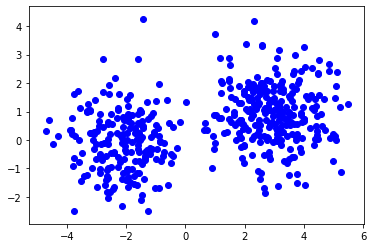

In [83]:
mean1 = [3,1]
cov1 = [[1,0],[0,1]]

mean2 = [-2,0]
cov2 = [[1, 0],[0,1]]

X = multivariate_normal.rvs(mean=mean1, cov=cov1, size=270)
X2 = multivariate_normal.rvs(mean=mean2, cov=cov2, size=200)

plt.scatter(X[:,0], X[:,1], c="blue")
plt.scatter(X2[:,0], X2[:,1], c="blue")

There are clearly two clusters of data points and so a standard Gaussian doesn't look like it would fit the bill here. One way we can yield more complex distributions is to take linear combinations of simpler ones. This is exactly how Gaussian Mixture Models (GMMs) are built, which have the following form: 

$$p(\pmb{x}) = \Sigma_{k=1}^{K} \pi_{k} \mathcal{N}(\pmb{x}\vert \pmb{\mu}_{k}, \pmb{\Sigma}_{k})$$

The probability distribution is a linear combination of distinct multivariate Gaussian distributions, weighted by the mixing components $\pi_{k}$. $K$ represents the number of components in the mixture model and the model parameters are: 

$$\pmb{\theta} = \{\pmb{\mu}_{k}, \pmb{\Sigma}_{k}, \pi_{k}\}_{k=1,\dots,K}$$

representing the mixture means, covaraiances and mixing components respectively. 

GMMs are widely used as a clustering technique, similar to k-means. In contrast to k-means however, data points are assigned probabalistically to a given cluster, so it's possible that a data point is assigned a proportion for each cluster, representing the relative strength of that data point belonging to that cluster. In order to motivate the need for latent variables, let's continue to attempt to maximise the mixture distribution above. With our usual i.i.d assumption, the log likelihood is: 

$$\ln p(\textbf{X}\vert \pmb{\theta}) = \Sigma_{n=1}^{N} \ln \{\Sigma_{k=1}^{K} \pi_{k} \mathcal{N}(\pmb{x}_{n}\vert \pmb{\mu}_{k}, \pmb{\Sigma}_{k})\}$$

Our logarithm now acts on a sum of Gaussians, rather than directly on a Gaussian as seen earlier. This means all our complex exponents aren't cancelled by a logarithm. Whilst this doesn't completly prohibit our ability to optimise the log likelihood, it's now a much harder problem. 

So, where do we proceed from here? Well, remember I said that latent variables were unobserved? In a clustering problem, we only observe the data and our aim is to determine cluster memberships for each data point. In the case of a GMM model, we can introduce a per data point latent variable $\pmb{z}_{n}$ taking on values $1 \dots K$ representing which of the Gaussian components this data point originated from. 

We define a prior over the latent variables using the mixing coefficients such that:

$$p(\pmb{z}_{n} = k \vert \pmb{\theta}) = \pi_{k}$$

Suppose, for a given data point we know the value of $\pmb{z}_{n}$ then the probability of the observations is given simply by:

$$p(\pmb{x} \vert \pmb{z}_{n} = k, \pmb{\theta}) = \mathcal{N}(\pmb{x} \vert \pmb{\mu}_{k}, \pmb{\Sigma}_{k})$$

Another useful quantity we'll require later is the posterior distribution on $z$ which can be written using the previous two results as: 

$$
\begin{align}
p(\pmb{z}_{n} = k \vert \pmb{x}, \pmb{\theta}) \propto & \hspace{2mm} p(\pmb{x} \vert \pmb{z}_{n} = k, \pmb{\theta})p(\pmb{z}_{n} = k \vert \pmb{\theta}) \\
\propto & \hspace{2mm} \pi_{k} \mathcal{N}(\pmb{x} \vert \pmb{\mu}_{k}, \pmb{\Sigma}_{k})
\end{align}
$$

we can normalise this distribution by marginalising over all mixture components:

$$
p(\pmb{z}_{n} = k \vert \pmb{x}, \pmb{\theta}) = \dfrac{\hspace{2mm} \pi_{k} \mathcal{N}(\pmb{x} \vert \pmb{\mu}_{k}, \pmb{\Sigma}_{k})}{\sum_{j=1}^{K} \pi_{j} \mathcal{N}(\pmb{x} \vert \pmb{\mu}_{j}, \pmb{\Sigma}_{j})} = \gamma(\pmb{z}_{nk})
$$

$\gamma(\pmb{z}_{nk})$ is called the responsibility that component $k$ takes for data point $\pmb{x}$. 

We have reinterpreted the GMM model in an equivalent formulation using the latent variables $\pmb{z}_{n}$. Why did we go to all this trouble? What did we gain? It turns out that the Expectation Maximisation is a technique specifically for finding maximum likelihood solutions in probabalistic models containing latent variables. We'll introduce this technique generally next, and see how it can be applied to reformulated GMM model. 

## Expectation Maximisation

Let $\textbf{X}$ represent our observed data, $\pmb{\theta}$ our model parameters and $\textbf{Z}$ the latent variables. We suppose that direct optimisation of the likelihood $p(\textbf{X}\vert\pmb{\theta})$ is hard and the complete data likelihood $p(\textbf{X}, \textbf{Z} \vert \pmb{\theta})$ is a much easier optimisation problem. 

Our goal is to maximise the log likelihood $p(\textbf{X}\vert \mathbf{\theta})$. Let's introduce a distribution $q$ over the latent variables. Then we can rearrange the log likelihood as follows: 


$$
\begin{align}
\log{p(\textbf{X} \vert \pmb{\theta})} =& \int{q(\textbf{Z})} \log{p(\textbf{X} \vert \pmb{\theta})}\hspace{1mm} dZ \\[5pt]
=& \int{q(\textbf{Z})} \log{\dfrac{p(\textbf{X}, \textbf{Z} \vert \pmb{\theta})}{p(\textbf{Z} \vert \textbf{X}, \pmb{\theta})}} \hspace{1mm} dZ \\[5pt]
=& \int{q(\textbf{Z})} \log{\dfrac{p(\textbf{X}, \textbf{Z} \vert \pmb{\theta})q(\textbf{Z})}{p(\textbf{Z} \vert \textbf{X}, \pmb{\theta})q(\textbf{Z})}} \hspace{1mm} dZ \\[5pt]
=& \underbrace{\int{q(\textbf{Z})} \log{\dfrac{p(\textbf{X}, \textbf{Z} \vert \pmb{\theta})}{q(\textbf{Z})}} \hspace{1mm} dZ}_{\text{ELBO}=\mathcal{L}(q, \pmb{\theta})} +  \underbrace{\int{q(\textbf{Z})} \log{\dfrac{q(\textbf{Z})}{p(\textbf{Z} \vert \textbf{X}, \pmb{\theta})}}}_{\text{KL}(q(\textbf{Z})\vert \vert p(\textbf{Z} \vert \textbf{X}, \pmb{\theta}))\geq 0} \hspace{1mm} dZ\\[5pt]
=& \mathcal{L}(q, \pmb{\theta}) + \text{KL}(q \vert\vert p)
\end{align}
$$

Since the $\ln{p(\textbf{X} \vert \pmb{\theta})}$ on the LHS does not depend on $\textbf{Z}$ and the KL-divergence $\geq 0$, it's clear that the ELBO forms a lower bound on the log-likelihood; therefore, instead of optimising $\ln{p(\textbf{X} \vert \pmb{\theta})}$, we instead optimise $\mathcal{L}(q, \pmb{\theta})$. The EM algorithm is a two stage block-coordinate alogrithm. The first stage fixes a value of $\pmb{\theta}$ and maximises $q$. The second stage fixes $q$ and maximises $\pmb{\theta}$. This two stage process is repeated until convergence.

### E-step
We know that maximising $\mathcal{L}(q, \theta)$ is the same as minimising $\text{KL}(q \vert\vert p)$. Further, the KL-divergence, $\text{KL}(q \vert\vert p)$, is zero when $p=q$. Therefore, start from initial point $\theta_{0}$ and compute: 

$$
q(Z) = \text{arg}\max_{q} \mathcal{L}(q, \theta) = \text{arg}\min_{q} \text{KL}(q(Z)\vert\vert p(Z \vert X, \theta) = p(Z \vert X, \theta_{0})
$$

### M-step

$$
\theta_{\text{new}} = \text{arg}\max_{\theta} \mathcal{L}(q, \theta) = \text{arg}\max_{\theta} \E_{q(Z)} \log p(X,Z \vert \theta)
$$

Set $\theta_{0} = \theta_{\text{new}}$ and repeat until convergence. 